# Equal variances in age acceleration between Near and Far cells

This notebook contains code for testing the hypothesis of equal variances in age acceleration of Near cells vs Far cells for all proximity effects. Generally, we find that most P-values resulting from this test are larger than a multiple hypothesis-corrected threshold for significance (against the null hypothesis of equal variance).

**Associated manuscript figures/tables:**
- Extended Data Figures: 9a


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)


**Conda environment used**: `requirements/merfish.txt`


In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind, levene
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

In [3]:
# Distance Cutoff Parameters -- see D1_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

## Proximity effect + equal variance testing

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [5]:
# compute age acceleration
get_age_acceleration (adata)

In [6]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [8]:
# Compute equal variance test stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
levene_p = []
celltype_target = []
celltype_effector = []

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        l,p = levene(sub_adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
                     sub_adata.obs['normalized_age_acceleration'].copy()[near_ages=="Far"],
                     center='median', proportiontocut=0.05)
        
        levene_p.append(p)
        celltype_target.append(ct)
        celltype_effector.append(celltype)

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom


/local/scratch/edsun/slrmtmp.43000709/ipykernel_30431/450212055.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.hist(-np.log10(levene_p), color='0.3',


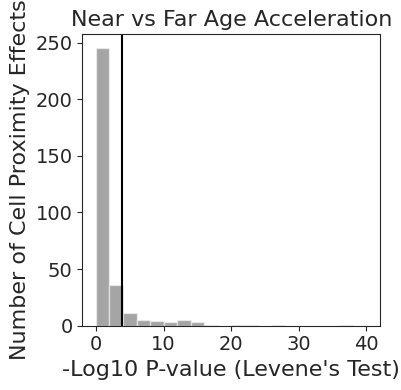

In [12]:
plt.figure(figsize=(4,4))
plt.axvline(-np.log10(0.05/len(levene_p)), color='k')
plt.hist(-np.log10(levene_p), color='0.3',
        alpha=0.5, range=(0,40), bins=20)
plt.title("Near vs Far Age Acceleration", fontsize=16)
plt.xlabel("-Log10 P-value (Levene's Test)", fontsize=16)
plt.ylabel("Number of Cell Proximity Effects", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/proximity/levene_test_ageaccel.pdf', dpi=300, bbox_inches='tight')
plt.show()